In [1]:
from typing import List
import sys
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/neuroforest-master')
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/deepHL')
import numpy as np
import json
import os
import time
from tqdm import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler

from main import dataloader, to_vect, Coordinates, calculate_asrs
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


Loading data from : C:\Users\TomFi\Desktop\Cours\Projet IA\data_2022\trajectories_processed


In [7]:
def create_batches(dataloader, session_type: str, batch_size: int):
    trajectories = []
    asrs = []

    for sample in dataloader:
        session = sample[session_type]
        if session is not None:
            player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])
            player_coords = player_coords[:, [0, 2]]  # Keep only x and z coordinates
            trajectories.append(player_coords)
        asrs_score = calculate_asrs(sample.answers)
        asrs.append(asrs_score)

    # Determine the minimum length of the trajectories
    length = min(len(traj) for traj in trajectories)

    # Truncate the trajectories to the minimum length
    truncated_trajectories = np.array([traj[:length] for traj in trajectories])
    tensor_trajectories = torch.tensor(truncated_trajectories, dtype=torch.float32)

    # Create batches
    num_batches = len(tensor_trajectories) // batch_size
    batches = tensor_trajectories[:num_batches * batch_size].view(num_batches, batch_size, length, 2)
    asrs = torch.tensor(np.array(asrs[:num_batches * batch_size])).view(num_batches, batch_size)
    return batches, asrs

# Create batches for "uniform" and "patchy" session types
batch_size = 1
uniform_batches,asrs = create_batches(dataloader, "uniform", batch_size)
high_probability_adhd = (np.array(asrs) >= 24).reshape(-1).astype(int)


# For each trajectory, select only 1 point every second, linearly spaced
uniform_batches = uniform_batches[:, :, ::25]

# Split the batches to a train and test
x_train = uniform_batches[:int(0.8 * len(uniform_batches))]
x_test = uniform_batches[int(0.8 * len(uniform_batches)):]
y_train = high_probability_adhd[:int(0.8 * len(uniform_batches))]
y_test = high_probability_adhd[int(0.8 * len(uniform_batches)):]
print(f"Train batches shape: {x_train.shape}")
print(f"Test batches shape: {x_test.shape}")


# patchy_batches,_ = create_batches(dataloader, "patchy", batch_size)
# print(f"Uniform batches shape: {uniform_batches.shape}")
# print(f"Patchy batches shape: {patchy_batches.shape}")

print(f"ASRS scores: {y_train}")

Train batches shape: torch.Size([31, 1, 1200, 2])
Test batches shape: torch.Size([8, 1, 1200, 2])
ASRS scores: [1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1]


IndexError: index 8 is out of bounds for dimension 0 with size 8

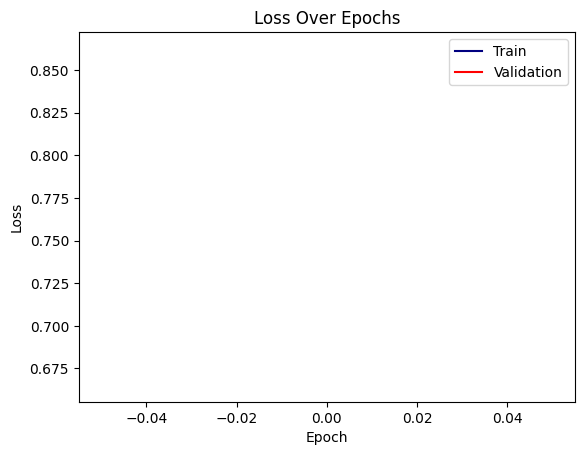

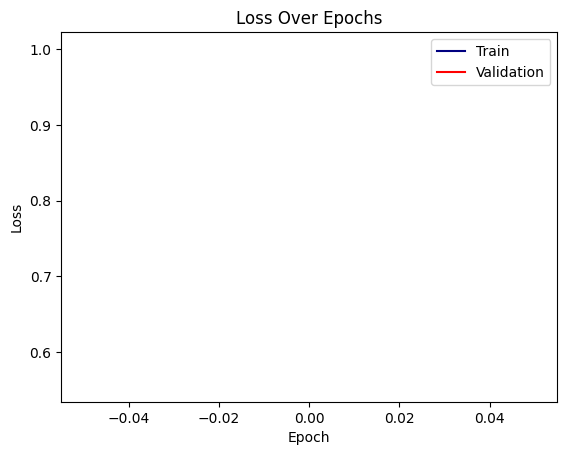

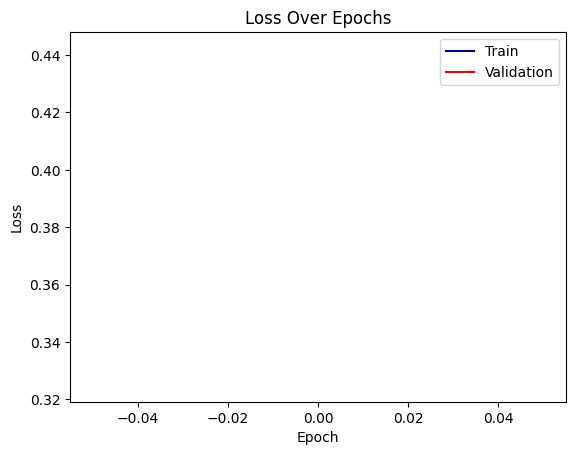

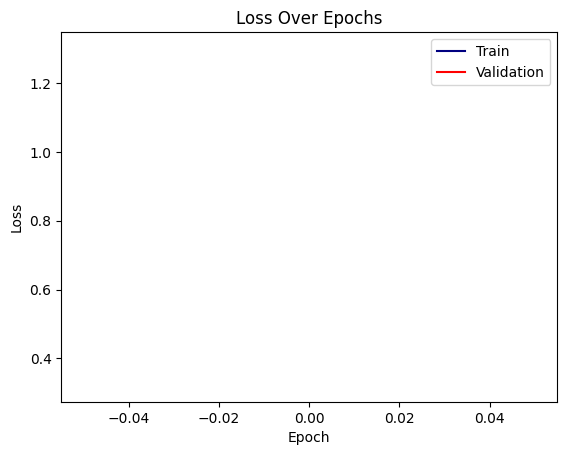

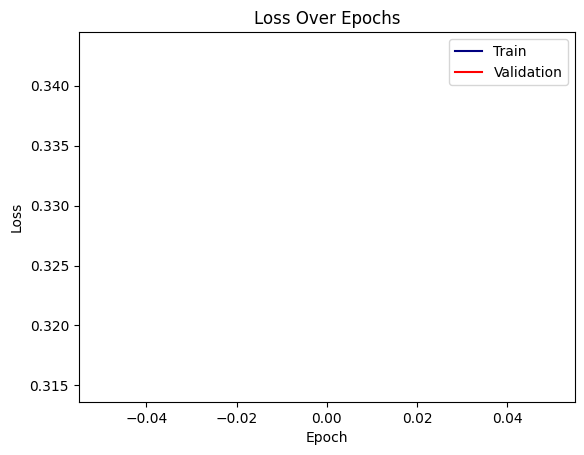

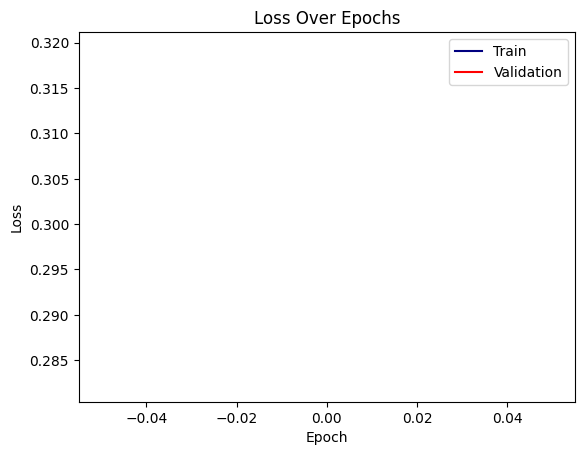

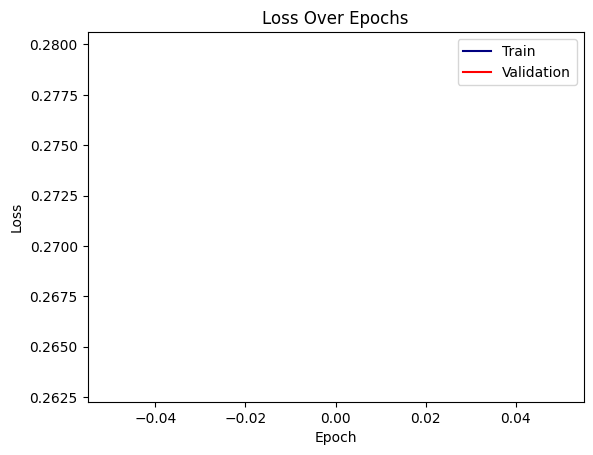

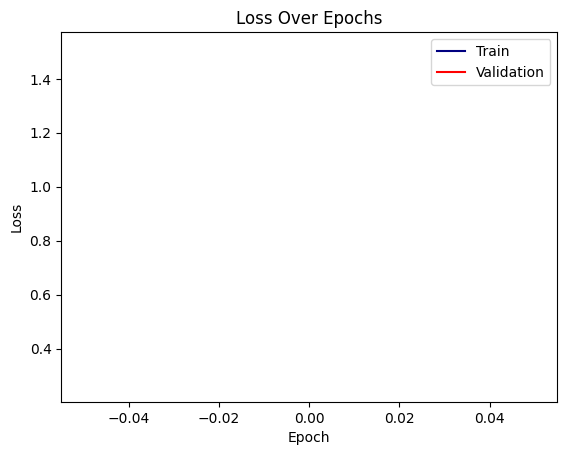

In [22]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dense2 = nn.Linear(1200,1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        seq_len = lstm_out.size(1)
        lstm_out = lstm_out.permute(1, 0, 2)
        # attn_mask = nn.Transformer.generate_square_subsequent_mask(seq_len)
        # attn_mask = attn_mask.unsqueeze(0).expand(x.size(0), -1, -1)  # Expand mask to (batch_size, seq_len, seq_len)
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)[0]
        dense_out = self.fc(attention_out).view(-1, 1200)
        dense_out = self.dense2(dense_out)
        probability = self.activation(dense_out)
        return probability

# Define the model parameters
input_dim = 2  # x and z coordinates
hidden_dim = 32
num_layers = 2
dropout = 0.3

# Instantiate the model
model = LSTMWithAttention(input_dim, hidden_dim, num_layers, dropout)
print(model)

# Define the loss function and optimizer
criterion = nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example training loop
num_epochs = 20
for epoch in range(num_epochs):
    for minibatch in range(x_train.shape[0]):
        x_train_batch = x_train[minibatch]
        y_train_batch = y_train[minibatch]
        x_test_batch = x_test[minibatch]
        y_test_batch = y_test[minibatch]
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_train_batch)
        loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # add validation on test set
        val_loss = criterion(model(x_test_batch).squeeze(), torch.tensor(y_test_batch, dtype=torch.float32))

        # print(f'Epoch {epoch+1}/{num_epochs}, Minibatch {minibatch+1}/{x_train.shape[0]}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        
        # Dynamic plot to showcase the evolution of the loss
        if epoch == 0:
            plt.ion()
            fig, ax = plt.subplots()
            losses = []
            val_losses = []

        losses.append(loss.item())
        val_losses.append(val_loss.item())
        ax.clear()
        ax.plot(losses, label='Train', color = 'navy')
        ax.plot(val_losses, label='Validation', color = 'r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Loss Over Epochs')
        ax.legend()
        display.display(fig)
        display.clear_output(wait=True)

In [15]:
# Testing outputs
model.eval()
outputs = model(x_test)
print(f"Predictions: {outputs.reshape(-1)}\n")
print(f"True values: {y_test.reshape(-1)}")

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [48]:
print(outputs)

tensor([[0.3700],
        [0.4564],
        [0.4359],
        [0.4825],
        [0.4481],
        [0.3079],
        [0.4668],
        [0.5411]], grad_fn=<AddmmBackward0>)
